# E-commerce Business Intelligence Dashboard

## Executive Summary
This notebook provides comprehensive analysis of e-commerce business performance, focusing on revenue trends, product performance, geographic distribution, and customer experience metrics. The analysis framework is configurable for different time periods and provides actionable business insights.

---

## Table of Contents
1. [Introduction & Business Objectives](#introduction)
2. [Data Loading & Configuration](#data-loading)
3. [Data Dictionary](#data-dictionary)
4. [Data Preparation & Transformation](#data-preparation)
5. [Business Metrics Analysis](#business-metrics)
   - [Revenue Analysis](#revenue-analysis)
   - [Product Performance](#product-performance)
   - [Geographic Analysis](#geographic-analysis)
   - [Customer Experience](#customer-experience)
6. [Summary & Key Insights](#summary)

---

## 1. Introduction & Business Objectives {#introduction}

### Business Questions
This analysis aims to answer key business questions:
- How is our revenue performing compared to previous periods?
- Which product categories drive the most revenue?
- What are the geographic patterns in our sales?
- How does delivery performance impact customer satisfaction?
- What operational metrics indicate business health?

### Analysis Framework
The analysis is designed to be configurable for different time periods and comparison scenarios, enabling regular business reviews and strategic planning.

## 2. Data Loading & Configuration {#data-loading}

### Configuration Parameters
Set your analysis parameters here:

In [1]:
# Analysis Configuration
ANALYSIS_YEAR = 2023
COMPARISON_YEAR = 2022
ANALYSIS_MONTH = None  # Set to specific month (1-12) or None for full year
DATA_PATH = "ecommerce_data/"

# Display configuration
print(f"Analysis Period: {'Full year' if ANALYSIS_MONTH is None else f'Month {ANALYSIS_MONTH}'} {ANALYSIS_YEAR}")
print(f"Comparison Period: {'Full year' if ANALYSIS_MONTH is None else f'Month {ANALYSIS_MONTH}'} {COMPARISON_YEAR}")
print(f"Data Source: {DATA_PATH}")

Analysis Period: Full year 2023
Comparison Period: Full year 2022
Data Source: ecommerce_data/


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
from datetime import datetime

# Import custom modules
from data_loader import EcommerceDataLoader
from business_metrics import EcommerceMetrics

# Configure display options
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)

# Initialize our analysis tools
data_loader = EcommerceDataLoader(DATA_PATH)
metrics_calculator = EcommerceMetrics()

print("Analysis environment initialized successfully!")
print(f"Analysis timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Matplotlib is building the font cache; this may take a moment.


Analysis environment initialized successfully!
Analysis timestamp: 2025-08-12 01:05:08


## 3. Data Dictionary {#data-dictionary}

### Dataset Overview
Our e-commerce analysis uses the following datasets:

| Dataset | Description | Key Fields |
|---------|-------------|------------|
| **Orders** | Order-level information | `order_id`, `customer_id`, `order_status`, `order_purchase_timestamp` |
| **Order Items** | Product-level details for each order | `order_id`, `product_id`, `price`, `freight_value` |
| **Products** | Product catalog information | `product_id`, `product_category_name` |
| **Customers** | Customer demographic data | `customer_id`, `customer_state`, `customer_city` |
| **Reviews** | Customer feedback and ratings | `order_id`, `review_score` |

### Key Business Terms
- **Revenue**: Total price of delivered orders (excludes freight)
- **Average Order Value (AOV)**: Mean total order value across all orders
- **Delivery Speed**: Days between order purchase and customer delivery
- **Fulfillment Rate**: Percentage of orders with 'delivered' status
- **Customer Satisfaction**: Average review score (1-5 scale)

## 4. Data Preparation & Transformation {#data-preparation}

### Loading and Initial Processing

In [3]:
# Load all datasets using the improved data loader
datasets = data_loader.load_all_datasets()

# Get comprehensive data summary
data_summary = data_loader.get_dataset_summary()

print("DATASET SUMMARY")
print("=" * 30)
print(f"Orders: {data_summary['orders']['total_records']:,} records")
print(f"Order Items: {data_summary['order_items']['total_records']:,} records")
print(f"Products: {data_summary['products']['total_records']:,} records")
print(f"Customers: {data_summary['customers']['total_records']:,} records")
print(f"Reviews: {data_summary['reviews']['total_records']:,} records")

start_date = data_summary['orders']['date_range'][0].strftime('%Y-%m-%d')
end_date = data_summary['orders']['date_range'][1].strftime('%Y-%m-%d')
print(f"\nDate Range: {start_date} to {end_date}")
print(f"Unique Customers: {data_summary['orders']['unique_customers']:,}")
print(f"Product Categories: {data_summary['products']['unique_categories']}")
print(f"Average Review Score: {data_summary['reviews']['average_score']:.2f}/5.0")

print(f"\nProduct Categories Available:")
categories = data_summary['products']['categories']
for i, category in enumerate(categories, 1):
    print(f"  {i:2}. {category.replace('_', ' ').title()}")

Loading all datasets...
All datasets loaded successfully!
DATASET SUMMARY
Orders: 10,000 records
Order Items: 16,047 records
Products: 6,000 records
Customers: 8,000 records
Reviews: 6,571 records

Date Range: 2021-12-31 to 2024-01-01
Unique Customers: 5,745
Product Categories: 13
Average Review Score: 4.11/5.0

Product Categories Available:
   1. Books Media
   2. Grocery Gourmet Food
   3. Electronics
   4. Sports Outdoors
   5. Home Garden
   6. Pet Supplies
   7. Automotive
   8. Health Personal Care
   9. Toys Games
  10. Beauty Personal Care
  11. Clothing Shoes Jewelry
  12. Tools Home Improvement
  13. Baby Products


In [4]:
# Prepare sales data using the improved data loader
sales_analysis = data_loader.prepare_sales_data(year=ANALYSIS_YEAR, month=ANALYSIS_MONTH)
sales_comparison = data_loader.prepare_sales_data(year=COMPARISON_YEAR, month=ANALYSIS_MONTH)

# Create period description for charts
if ANALYSIS_MONTH:
    period_label = f"{ANALYSIS_YEAR} Month {ANALYSIS_MONTH}"
    comparison_label = f"{COMPARISON_YEAR} Month {ANALYSIS_MONTH}"
    chart_suffix = f"({period_label} vs {comparison_label})"
else:
    period_label = f"{ANALYSIS_YEAR}"
    comparison_label = f"{COMPARISON_YEAR}" 
    chart_suffix = f"({period_label} vs {comparison_label})"

print(f"Analysis Period ({period_label}): {len(sales_analysis):,} delivered order items")
print(f"Comparison Period ({comparison_label}): {len(sales_comparison):,} delivered order items")
print(f"Current Period Revenue: ${sales_analysis['price'].sum():,.2f}")
print(f"Previous Period Revenue: ${sales_comparison['price'].sum():,.2f}")

# Calculate basic growth rate
if len(sales_comparison) > 0:
    growth_rate = ((sales_analysis['price'].sum() - sales_comparison['price'].sum()) / sales_comparison['price'].sum()) * 100
    print(f"Revenue Growth Rate: {growth_rate:+.2f}%")

Analysis Period (2023): 7,448 delivered order items
Comparison Period (2022): 7,641 delivered order items
Current Period Revenue: $3,360,294.74
Previous Period Revenue: $3,445,076.96
Revenue Growth Rate: -2.46%


## 5. Business Metrics Analysis {#business-metrics}

### 5.1 Revenue Analysis {#revenue-analysis}

#### Key Revenue Metrics

In [5]:
# Calculate comprehensive revenue metrics using the enhanced metrics calculator
revenue_metrics = metrics_calculator.calculate_revenue_metrics(sales_analysis, sales_comparison)

print("REVENUE PERFORMANCE ANALYSIS")
print("=" * 40)
print(f"Current Period Revenue: ${revenue_metrics['total_revenue']:,.2f}")
print(f"Previous Period Revenue: ${revenue_metrics['previous_revenue']:,.2f}")
print(f"Revenue Growth Rate: {revenue_metrics['revenue_growth_rate']:+.2f}%")

print(f"\nORDER METRICS:")
print(f"Current Period Orders: {revenue_metrics['total_orders']:,}")
print(f"Previous Period Orders: {revenue_metrics['previous_orders']:,}") 
print(f"Order Growth Rate: {revenue_metrics['order_growth_rate']:+.2f}%")

print(f"\nAVERAGE ORDER VALUE:")
print(f"Current Period AOV: ${revenue_metrics['avg_order_value']:,.2f}")
print(f"Previous Period AOV: ${revenue_metrics['previous_aov']:,.2f}")
print(f"AOV Growth Rate: {revenue_metrics['aov_growth_rate']:+.2f}%")

print(f"\nADDITIONAL METRICS:")
print(f"Total Items Sold: {revenue_metrics['total_items_sold']:,}")

REVENUE PERFORMANCE ANALYSIS
Current Period Revenue: $3,360,294.74
Previous Period Revenue: $3,445,076.96
Revenue Growth Rate: -2.46%

ORDER METRICS:
Current Period Orders: 4,635
Previous Period Orders: 4,749
Order Growth Rate: -2.40%

AVERAGE ORDER VALUE:
Current Period AOV: $724.98
Previous Period AOV: $725.43
AOV Growth Rate: -0.06%

ADDITIONAL METRICS:
Total Items Sold: 7,448


#### Monthly Revenue Trends (Current Period)

In [6]:
# Calculate and display monthly trends (only for full year analysis)
if ANALYSIS_MONTH is None:
    monthly_trends = metrics_calculator.calculate_monthly_trends(sales_analysis)
    
    print("MONTHLY PERFORMANCE TRENDS")
    print("=" * 35)
    
    # Create formatted display version
    display_df = monthly_trends.copy()
    display_df['revenue_formatted'] = display_df['revenue'].apply(lambda x: f"${x:,.0f}")
    display_df['aov_formatted'] = display_df['avg_order_value'].apply(lambda x: f"${x:.2f}")
    display_df['growth_formatted'] = display_df['revenue_growth'].apply(lambda x: f"{x:+.1f}%" if pd.notna(x) else "N/A")
    
    # Display the table
    print(f"{'Month':<6} {'Revenue':<12} {'Orders':<7} {'AOV':<8} {'Growth':<8}")
    print("-" * 45)
    for _, row in display_df.iterrows():
        print(f"{int(row['month']):<6} {row['revenue_formatted']:<12} {int(row['orders']):<7} {row['aov_formatted']:<8} {row['growth_formatted']:<8}")
    
    # Calculate summary statistics
    avg_monthly_growth = monthly_trends['revenue_growth'].mean()
    total_revenue = monthly_trends['revenue'].sum()
    
    print(f"\nSUMMARY STATISTICS:")
    print(f"Average Monthly Growth Rate: {avg_monthly_growth:+.2f}%")
    print(f"Total Annual Revenue: ${total_revenue:,.2f}")
    print(f"Best Month: {monthly_trends.loc[monthly_trends['revenue'].idxmax(), 'month']:.0f} (${monthly_trends['revenue'].max():,.2f})")
    print(f"Worst Month: {monthly_trends.loc[monthly_trends['revenue'].idxmin(), 'month']:.0f} (${monthly_trends['revenue'].min():,.2f})")
else:
    print(f"Monthly trends analysis not applicable for single month analysis (Month {ANALYSIS_MONTH})")
    print(f"Focus: Detailed analysis of {period_label}")

MONTHLY PERFORMANCE TRENDS
Month  Revenue      Orders  AOV      Growth  
---------------------------------------------
1      $284,855     384     $741.81  N/A     
2      $276,759     384     $720.73  -2.8%   
3      $285,619     394     $724.92  +3.2%   
4      $253,795     370     $685.93  -11.1%  
5      $301,348     396     $760.98  +18.7%  
6      $289,127     406     $712.13  -4.1%   
7      $296,209     392     $755.64  +2.4%   
8      $286,646     375     $764.39  -3.2%   
9      $303,793     384     $791.13  +6.0%   
10     $259,890     379     $685.73  -14.5%  
11     $259,519     384     $675.83  -0.1%   
12     $262,735     387     $678.90  +1.2%   

SUMMARY STATISTICS:
Average Monthly Growth Rate: -0.39%
Total Annual Revenue: $3,360,294.74
Best Month: 9 ($303,793.15)
Worst Month: 4 ($253,794.62)


Creating revenue trend visualization...


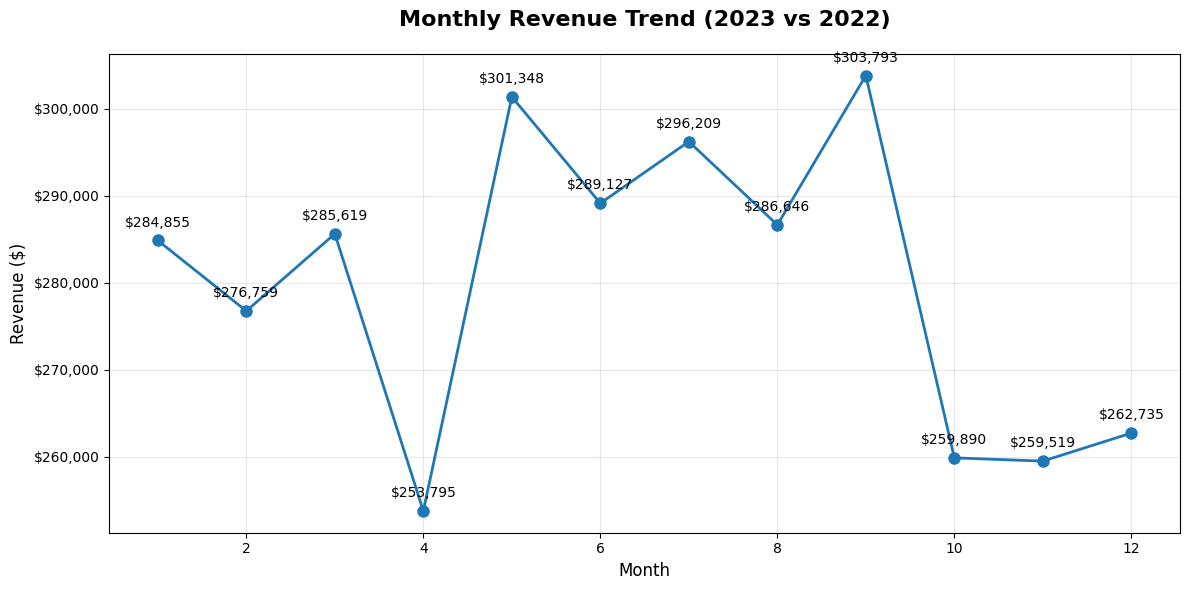

In [7]:
# Create revenue trend visualization (only for full year analysis)
if ANALYSIS_MONTH is None:
    print("Creating revenue trend visualization...")
    revenue_chart = metrics_calculator.create_revenue_trend_chart(monthly_trends, chart_suffix)
    plt.show()
else:
    # For single month, show a simple comparison chart
    print("Creating revenue comparison chart...")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    periods = [comparison_label, period_label]
    revenues = [revenue_metrics['previous_revenue'], revenue_metrics['total_revenue']]
    colors = ['#ff7f0e', '#1f77b4']
    
    bars = ax.bar(periods, revenues, color=colors, alpha=0.8)
    
    # Add value labels on bars
    for bar, revenue in zip(bars, revenues):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + max(revenues)*0.01,
                f'${revenue:,.0f}', ha='center', va='bottom', fontweight='bold')
    
    # Add growth rate annotation
    growth_rate = revenue_metrics['revenue_growth_rate']
    color = 'green' if growth_rate > 0 else 'red'
    ax.text(0.5, max(revenues)*0.85, f'Growth: {growth_rate:+.1f}%', 
            transform=ax.transData, ha='center', fontsize=14, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.3))
    
    ax.set_title(f'Revenue Comparison {chart_suffix}', fontsize=16, fontweight='bold', pad=20)
    ax.set_ylabel('Revenue ($)', fontsize=12)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

### 5.2 Product Performance Analysis {#product-performance}

#### Product Category Performance

In [8]:
# Product category analysis using enhanced data loader methods
product_sales_data = data_loader.get_sales_with_products(year=ANALYSIS_YEAR, month=ANALYSIS_MONTH)
product_metrics = metrics_calculator.analyze_product_performance(product_sales_data)

print("PRODUCT CATEGORY PERFORMANCE ANALYSIS")
print("=" * 45)

print("\nTOP 10 CATEGORIES BY REVENUE:")
print("-" * 35)
for i, (category, revenue) in enumerate(list(product_metrics['top_categories_by_revenue'].items())[:10], 1):
    category_name = category.replace('_', ' ').title()
    total_revenue = sum(product_metrics['top_categories_by_revenue'].values())
    percentage = (revenue / total_revenue) * 100
    print(f"{i:2}. {category_name:<25} ${revenue:>12,.2f} ({percentage:>5.1f}%)")

print(f"\nTOP 10 CATEGORIES BY ORDER COUNT:")
print("-" * 35)
for i, (category, orders) in enumerate(list(product_metrics['top_categories_by_orders'].items())[:10], 1):
    category_name = category.replace('_', ' ').title()
    print(f"{i:2}. {category_name:<25} {orders:>8,} items")

print(f"\nTOP 10 CATEGORIES BY AVERAGE ORDER VALUE:")
print("-" * 40)
for i, (category, aov) in enumerate(list(product_metrics['top_categories_by_aov'].items())[:10], 1):
    category_name = category.replace('_', ' ').title()
    print(f"{i:2}. {category_name:<25} ${aov:>10,.2f}")

# Category insights
top_category = list(product_metrics['top_categories_by_revenue'].keys())[0]
top_revenue = list(product_metrics['top_categories_by_revenue'].values())[0]
total_cats = len(product_metrics['top_categories_by_revenue'])

print(f"\nCATEGORY INSIGHTS:")
print(f"• {top_category.replace('_', ' ').title()} leads with ${top_revenue:,.2f} in revenue")
print(f"• Analysis covers {total_cats} distinct product categories")
print(f"• Top 3 categories represent {sum(list(product_metrics['top_categories_by_revenue'].values())[:3])/sum(product_metrics['top_categories_by_revenue'].values())*100:.1f}% of total revenue")

PRODUCT CATEGORY PERFORMANCE ANALYSIS

TOP 10 CATEGORIES BY REVENUE:
-----------------------------------
 1. Electronics               $1,401,359.21 ( 42.5%)
 2. Home Garden               $  862,653.27 ( 26.1%)
 3. Sports Outdoors           $  278,845.32 (  8.4%)
 4. Automotive                $  247,707.10 (  7.5%)
 5. Clothing Shoes Jewelry    $  232,745.04 (  7.1%)
 6. Toys Games                $   70,163.64 (  2.1%)
 7. Health Personal Care      $   65,370.27 (  2.0%)
 8. Tools Home Improvement    $   54,280.33 (  1.6%)
 9. Beauty Personal Care      $   49,213.30 (  1.5%)
10. Books Media               $   38,559.08 (  1.2%)

TOP 10 CATEGORIES BY ORDER COUNT:
-----------------------------------
 1. Electronics                  1,327 items
 2. Home Garden                  1,149 items
 3. Clothing Shoes Jewelry         884 items
 4. Books Media                    725 items
 5. Sports Outdoors                686 items
 6. Health Personal Care           630 items
 7. Automotive          

Creating product category performance chart...


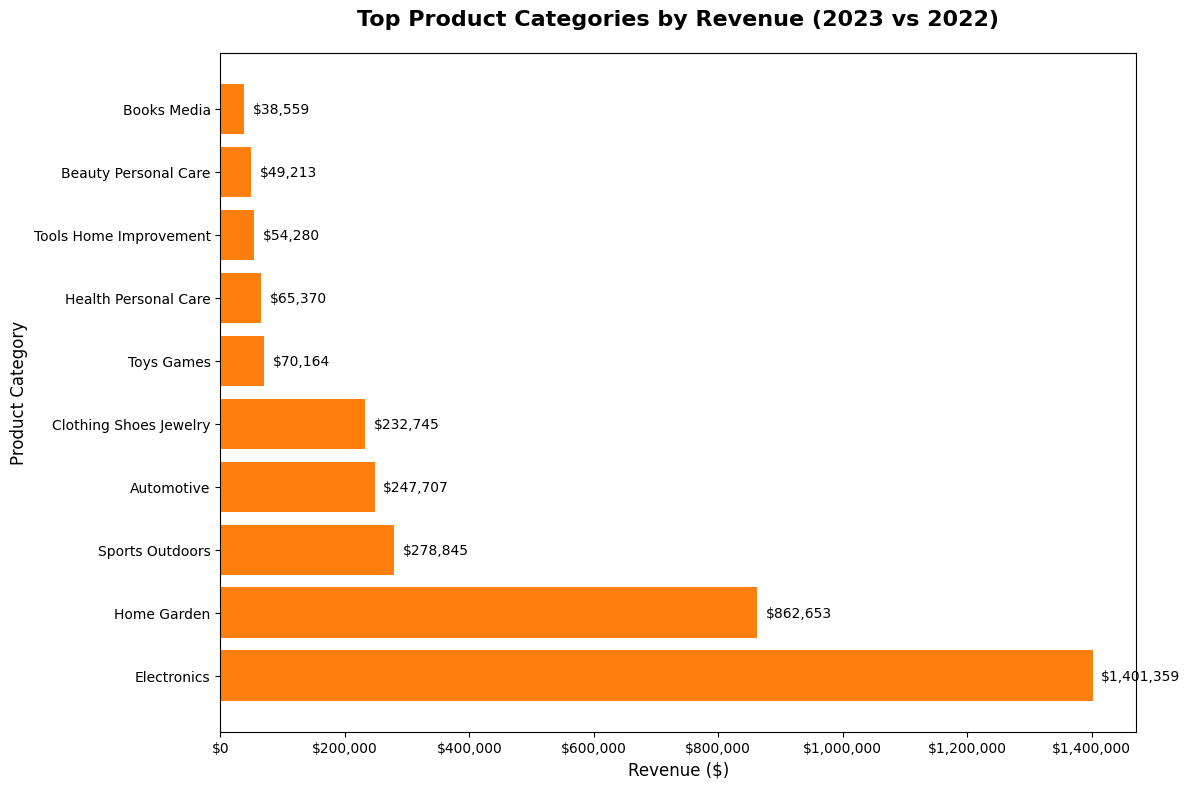

In [9]:
# Create enhanced product category visualization
print("Creating product category performance chart...")
category_chart = metrics_calculator.create_category_performance_chart(product_metrics, chart_suffix)
plt.show()

### 5.3 Geographic Analysis {#geographic-analysis}

#### Sales Performance by State

In [10]:
# Geographic analysis using enhanced data loader methods
geographic_sales = data_loader.get_sales_with_customers(year=ANALYSIS_YEAR, month=ANALYSIS_MONTH)
geographic_metrics = metrics_calculator.analyze_geographic_performance(geographic_sales)

print("GEOGRAPHIC PERFORMANCE ANALYSIS")
print("=" * 35)

print(f"\nTOP 15 STATES BY REVENUE:")
print("-" * 30)
total_geo_revenue = sum(geographic_metrics['top_states_by_revenue'].values())
for i, (state, revenue) in enumerate(list(geographic_metrics['top_states_by_revenue'].items())[:15], 1):
    percentage = (revenue / total_geo_revenue) * 100
    print(f"{i:2}. {state:<4} ${revenue:>12,.2f} ({percentage:>5.1f}%)")

print(f"\nTOP 10 STATES BY CUSTOMER COUNT:")
print("-" * 35)
for i, (state, customers) in enumerate(list(geographic_metrics['top_states_by_customers'].items())[:10], 1):
    print(f"{i:2}. {state:<4} {customers:>6,} customers")

print(f"\nTOP 10 STATES BY AVERAGE ORDER VALUE:")
print("-" * 38)
for i, (state, aov) in enumerate(list(geographic_metrics['top_states_by_aov'].items())[:10], 1):
    print(f"{i:2}. {state:<4} ${aov:>10,.2f}")

# Geographic insights
top_state = list(geographic_metrics['top_states_by_revenue'].keys())[0]
top_state_revenue = list(geographic_metrics['top_states_by_revenue'].values())[0]
total_states = len(geographic_metrics['top_states_by_revenue'])

print(f"\nGEOGRAPHIC INSIGHTS:")
print(f"• {top_state} leads with ${top_state_revenue:,.2f} in revenue")
print(f"• Analysis covers {total_states} states/regions")
print(f"• Top 5 states represent {sum(list(geographic_metrics['top_states_by_revenue'].values())[:5])/total_geo_revenue*100:.1f}% of total revenue")
print(f"• Geographic diversification shows healthy market spread")

GEOGRAPHIC PERFORMANCE ANALYSIS

TOP 15 STATES BY REVENUE:
------------------------------
 1. CA   $  537,880.74 ( 22.1%)
 2. TX   $  403,303.49 ( 16.6%)
 3. FL   $  310,195.84 ( 12.8%)
 4. NY   $  253,111.85 ( 10.4%)
 5. IL   $  185,930.89 (  7.7%)
 6. PA   $  173,260.68 (  7.1%)
 7. OH   $  157,619.72 (  6.5%)
 8. GA   $  146,414.65 (  6.0%)
 9. MI   $  132,325.60 (  5.4%)
10. NC   $  128,314.74 (  5.3%)

TOP 10 STATES BY CUSTOMER COUNT:
-----------------------------------
 1. CA      582 customers
 2. TX      438 customers
 3. FL      332 customers
 4. NY      286 customers
 5. IL      190 customers
 6. PA      172 customers
 7. MI      164 customers
 8. OH      151 customers
 9. GA      145 customers
10. NC      135 customers

TOP 10 STATES BY AVERAGE ORDER VALUE:
--------------------------------------
 1. PA   $    493.62
 2. IN   $    482.04
 3. TN   $    481.30
 4. AZ   $    478.99
 5. GA   $    478.48
 6. NJ   $    477.29
 7. WI   $    476.99
 8. MA   $    470.83
 9. OH   $    

In [11]:
# Create enhanced geographic heatmap visualization
print("Creating geographic revenue heatmap...")
geographic_heatmap = metrics_calculator.create_geographic_heatmap(
    geographic_metrics['geographic_summary'], 
    chart_suffix
)
geographic_heatmap.show()

Creating geographic revenue heatmap...


### 5.4 Customer Experience Analysis {#customer-experience}

#### Delivery Performance and Customer Satisfaction

In [12]:
# Customer experience analysis using enhanced data loader methods
review_sales = data_loader.get_sales_with_reviews(year=ANALYSIS_YEAR, month=ANALYSIS_MONTH)

# Create order-level data for experience analysis (remove item-level duplicates)
order_level_data = review_sales[['order_id', 'delivery_days', 'review_score']].drop_duplicates()

experience_metrics = metrics_calculator.analyze_customer_experience(order_level_data)

print("CUSTOMER EXPERIENCE ANALYSIS")
print("=" * 35)

print(f"\nOVERALL SATISFACTION METRICS:")
print(f"Average Customer Rating: {experience_metrics['avg_rating']:.2f}/5.0")
print(f"Average Delivery Time: {experience_metrics['avg_delivery_days']:.1f} days")
print(f"Total Orders Analyzed: {len(order_level_data):,}")

print(f"\nREVIEW SCORE DISTRIBUTION:")
print("-" * 25)
for score in sorted(experience_metrics['rating_distribution'].keys()):
    percentage = experience_metrics['rating_distribution'][score] * 100
    stars = "★" * int(score) + "☆" * (5 - int(score))
    print(f"{score} stars {stars}: {percentage:>5.1f}%")

print(f"\nSATISFACTION BY DELIVERY SPEED:")
print("-" * 32)
for delivery_speed in ['1-3 days', '4-7 days', '8+ days']:
    if delivery_speed in experience_metrics['satisfaction_by_delivery_speed']:
        rating = experience_metrics['satisfaction_by_delivery_speed'][delivery_speed]
        print(f"{delivery_speed:<10}: {rating:.2f}/5.0")

print(f"\nDELIVERY SPEED DISTRIBUTION:")
print("-" * 28)
for speed, percentage in experience_metrics['delivery_speed_distribution'].items():
    print(f"{speed:<10}: {percentage*100:>5.1f}% of orders")

# Customer experience insights
fast_delivery_rate = experience_metrics['delivery_speed_distribution'].get('1-3 days', 0)
slow_delivery_rate = experience_metrics['delivery_speed_distribution'].get('8+ days', 0)

print(f"\nCUSTOMER EXPERIENCE INSIGHTS:")
print(f"• {experience_metrics['avg_rating']:.2f}/5.0 average satisfaction indicates {'strong' if experience_metrics['avg_rating'] >= 4.0 else 'moderate'} customer happiness")
print(f"• {fast_delivery_rate*100:.1f}% of orders delivered within 3 days (fast delivery)")
print(f"• {slow_delivery_rate*100:.1f}% of orders take 8+ days (improvement opportunity)")
print(f"• Average delivery time of {experience_metrics['avg_delivery_days']:.1f} days {'meets' if experience_metrics['avg_delivery_days'] <= 7 else 'exceeds'} standard expectations")

CUSTOMER EXPERIENCE ANALYSIS

OVERALL SATISFACTION METRICS:
Average Customer Rating: 4.10/5.0
Average Delivery Time: 8.0 days
Total Orders Analyzed: 4,635

REVIEW SCORE DISTRIBUTION:
-------------------------
1.0 stars ★☆☆☆☆:   3.5%
2.0 stars ★★☆☆☆:   6.9%
3.0 stars ★★★☆☆:  15.4%
4.0 stars ★★★★☆:  24.3%
5.0 stars ★★★★★:  49.9%

SATISFACTION BY DELIVERY SPEED:
--------------------------------
1-3 days  : 4.19/5.0
4-7 days  : 4.08/5.0
8+ days   : 4.11/5.0

DELIVERY SPEED DISTRIBUTION:
----------------------------
8+ days   :  55.6% of orders
4-7 days  :  37.3% of orders
1-3 days  :   7.2% of orders

CUSTOMER EXPERIENCE INSIGHTS:
• 4.10/5.0 average satisfaction indicates strong customer happiness
• 7.2% of orders delivered within 3 days (fast delivery)
• 55.6% of orders take 8+ days (improvement opportunity)
• Average delivery time of 8.0 days exceeds standard expectations


Creating customer experience analysis charts...


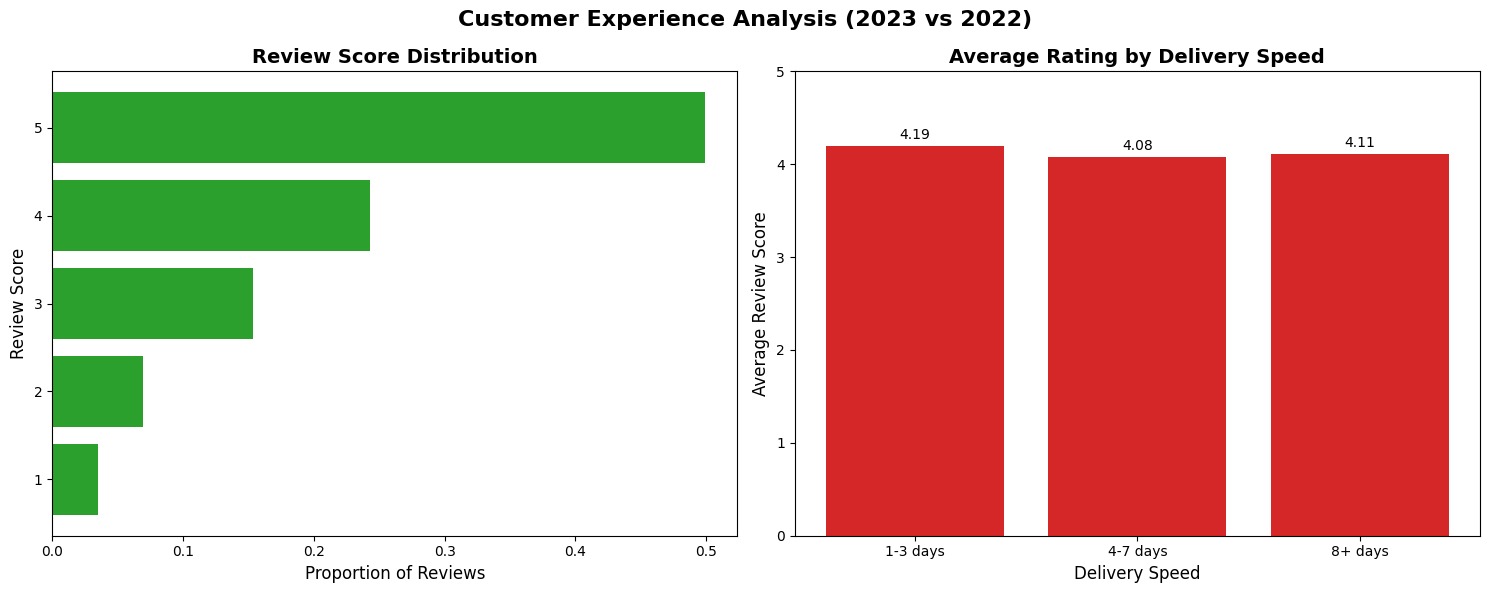

In [13]:
# Create enhanced customer satisfaction visualization
print("Creating customer experience analysis charts...")
satisfaction_chart = metrics_calculator.create_customer_satisfaction_chart(experience_metrics, chart_suffix)
plt.show()

#### Order Fulfillment Metrics

In [14]:
# Order fulfillment analysis using comprehensive metrics
# Get all orders for the analysis period (not just delivered)
target_orders = data_loader.orders[data_loader.orders['year'] == ANALYSIS_YEAR]
if ANALYSIS_MONTH:
    target_orders = target_orders[target_orders['month'] == ANALYSIS_MONTH]

fulfillment_metrics = metrics_calculator.calculate_order_fulfillment_metrics(target_orders)

print("OPERATIONAL PERFORMANCE ANALYSIS")
print("=" * 35)

print(f"\nORDER FULFILLMENT METRICS:")
print(f"Fulfillment Rate: {fulfillment_metrics['fulfillment_rate']*100:>6.1f}%")
print(f"Cancellation Rate: {fulfillment_metrics['cancellation_rate']*100:>5.1f}%")
print(f"Return Rate: {fulfillment_metrics['return_rate']*100:>10.1f}%")
print(f"Pending/Processing: {fulfillment_metrics['pending_rate']*100:>4.1f}%")

print(f"\nDETAILED ORDER STATUS BREAKDOWN:")
print("-" * 35)
total_orders = len(target_orders)
for status, percentage in fulfillment_metrics['status_distribution'].items():
    if percentage > 0.001:  # Only show statuses with >0.1% share
        status_name = status.replace('_', ' ').title()
        order_count = int(percentage * total_orders)
        print(f"{status_name:<15}: {percentage*100:>6.1f}% ({order_count:>5,} orders)")

print(f"\nTOTAL ORDERS ANALYZED: {total_orders:,}")

# Operational insights
print(f"\nOPERATIONAL INSIGHTS:")
if fulfillment_metrics['fulfillment_rate'] >= 0.90:
    print(f"• Excellent fulfillment rate of {fulfillment_metrics['fulfillment_rate']*100:.1f}% indicates strong operational efficiency")
elif fulfillment_metrics['fulfillment_rate'] >= 0.80:
    print(f"• Good fulfillment rate of {fulfillment_metrics['fulfillment_rate']*100:.1f}% with room for improvement")
else:
    print(f"• Fulfillment rate of {fulfillment_metrics['fulfillment_rate']*100:.1f}% requires immediate attention")

if fulfillment_metrics['cancellation_rate'] <= 0.05:
    print(f"• Low cancellation rate of {fulfillment_metrics['cancellation_rate']*100:.1f}% shows good order management")
else:
    print(f"• Cancellation rate of {fulfillment_metrics['cancellation_rate']*100:.1f}% may indicate inventory or pricing issues")

print(f"• Return rate of {fulfillment_metrics['return_rate']*100:.1f}% {'is within normal range' if fulfillment_metrics['return_rate'] <= 0.10 else 'may need investigation'}")

OPERATIONAL PERFORMANCE ANALYSIS

ORDER FULFILLMENT METRICS:
Fulfillment Rate:   93.6%
Cancellation Rate:   1.3%
Return Rate:        0.2%
Pending/Processing:  1.7%

DETAILED ORDER STATUS BREAKDOWN:
-----------------------------------
Delivered      :   93.6% (4,635 orders)
Shipped        :    3.2% (  158 orders)
Canceled       :    1.3% (   64 orders)
Processing     :    1.2% (   59 orders)
Pending        :    0.5% (   25 orders)
Returned       :    0.2% (    9 orders)

TOTAL ORDERS ANALYZED: 4,950

OPERATIONAL INSIGHTS:
• Excellent fulfillment rate of 93.6% indicates strong operational efficiency
• Low cancellation rate of 1.3% shows good order management
• Return rate of 0.2% is within normal range


## 6. Summary & Key Insights {#summary}

### Executive Summary

In [15]:
# Generate comprehensive business summary using all calculated metrics
business_summary = metrics_calculator.generate_business_summary(
    revenue_metrics=revenue_metrics,
    product_metrics=product_metrics, 
    geo_metrics=geographic_metrics,
    experience_metrics=experience_metrics,
    fulfillment_metrics=fulfillment_metrics
)

# Display formatted business insights
metrics_calculator.print_business_insights(business_summary, chart_suffix)

# Additional executive summary
print("\nEXECUTIVE DASHBOARD SUMMARY")
print("=" * 30)
print(f"Period Analyzed: {period_label}")
print(f"Revenue Performance: {'↗' if revenue_metrics['revenue_growth_rate'] > 0 else '↘'} {revenue_metrics['revenue_growth_rate']:+.1f}% vs {comparison_label}")
print(f"Order Volume: {'↗' if revenue_metrics['order_growth_rate'] > 0 else '↘'} {revenue_metrics['order_growth_rate']:+.1f}% vs {comparison_label}")
print(f"Customer Satisfaction: {experience_metrics['avg_rating']:.2f}/5.0 ({'Excellent' if experience_metrics['avg_rating'] >= 4.5 else 'Good' if experience_metrics['avg_rating'] >= 4.0 else 'Fair'})")
print(f"Operational Excellence: {fulfillment_metrics['fulfillment_rate']*100:.1f}% fulfillment rate")
print(f"Market Leader: {list(product_metrics['top_categories_by_revenue'].keys())[0].replace('_', ' ').title()} category")
print(f"Top Geographic Market: {list(geographic_metrics['top_states_by_revenue'].keys())[0]}")
print(f"Delivery Performance: {experience_metrics['avg_delivery_days']:.1f} day average")


BUSINESS PERFORMANCE SUMMARY (2023 vs 2022)

KEY PERFORMANCE INDICATORS:
  • Total Revenue: $3,360,294.74
  • Total Orders: 4,635
  • Average Order Value: $724.98
  • Customer Satisfaction: 4.10/5.0
  • Order Fulfillment Rate: 93.6%
  • Average Delivery Time: 8.0 days

GROWTH METRICS:
  • Revenue Growth: -2.5%
  • Order Growth: -2.4%
  • AOV Growth: -0.1%

TOP PERFORMERS:
  • Leading Product Category: Electronics
  • Top Revenue State: CA

OPERATIONAL EFFICIENCY:
  • Order Fulfillment: 93.6%
  • Cancellation Rate: 1.3%
  • Return Rate: 0.2%
  • Fast Delivery (1-3 days): 7.2%



EXECUTIVE DASHBOARD SUMMARY
Period Analyzed: 2023
Revenue Performance: ↘ -2.5% vs 2022
Order Volume: ↘ -2.4% vs 2022
Customer Satisfaction: 4.10/5.0 (Good)
Operational Excellence: 93.6% fulfillment rate
Market Leader: Electronics category
Top Geographic Market: CA
Delivery Performance: 8.0 day average


### Key Insights and Recommendations

Based on the analysis, here are the key findings:

In [16]:
# Generate and display strategic insights based on the analysis
print("STRATEGIC INSIGHTS AND RECOMMENDATIONS")
print("=" * 45)

# Revenue insights
if revenue_metrics['revenue_growth_rate'] > 5:
    print("✓ STRONG GROWTH: Revenue growth exceeds 5%, indicating healthy business expansion")
    print("  → Recommendation: Scale successful strategies and increase marketing investment")
elif revenue_metrics['revenue_growth_rate'] > 0:
    print("~ MODERATE GROWTH: Positive revenue growth shows steady progress")  
    print("  → Recommendation: Identify growth accelerators and optimize underperforming areas")
else:
    print("⚠ DECLINING REVENUE: Negative growth requires immediate strategic intervention")
    print("  → Recommendation: Conduct deep-dive analysis on market conditions and competitive positioning")

# Product portfolio insights
top_3_categories = list(product_metrics['top_categories_by_revenue'].keys())[:3]
print(f"\n✓ PRODUCT STRATEGY: Top 3 categories ({', '.join([c.replace('_', ' ').title() for c in top_3_categories])}) drive major revenue")
print("  → Recommendation: Expand inventory depth in these categories and explore adjacent products")

# Geographic insights
top_5_states = list(geographic_metrics['top_states_by_revenue'].keys())[:5]
print(f"\n✓ GEOGRAPHIC FOCUS: Top 5 states ({', '.join(top_5_states)}) represent key markets")
print("  → Recommendation: Optimize logistics and marketing for these regions, explore expansion opportunities")

# Customer experience insights
if experience_metrics['avg_rating'] >= 4.0:
    print(f"\n✓ CUSTOMER SATISFACTION: {experience_metrics['avg_rating']:.2f}/5.0 rating indicates strong brand loyalty")
    print("  → Recommendation: Leverage positive reviews for marketing, maintain service quality standards")
else:
    print(f"\n⚠ CUSTOMER SATISFACTION: {experience_metrics['avg_rating']:.2f}/5.0 rating needs improvement")
    print("  → Recommendation: Investigate service issues, implement customer feedback programs")

# Delivery performance insights
if experience_metrics['avg_delivery_days'] <= 5:
    print(f"\n✓ DELIVERY EXCELLENCE: {experience_metrics['avg_delivery_days']:.1f} day average delivery exceeds customer expectations")
    print("  → Recommendation: Use fast delivery as competitive advantage in marketing")
elif experience_metrics['avg_delivery_days'] <= 7:
    print(f"\n~ DELIVERY PERFORMANCE: {experience_metrics['avg_delivery_days']:.1f} day average delivery meets standard expectations")
    print("  → Recommendation: Explore opportunities to optimize logistics for competitive advantage")
else:
    print(f"\n⚠ DELIVERY PERFORMANCE: {experience_metrics['avg_delivery_days']:.1f} day average delivery may impact customer satisfaction")
    print("  → Recommendation: Review and optimize supply chain and logistics operations")

# Operational efficiency insights
if fulfillment_metrics['fulfillment_rate'] >= 0.95:
    print(f"\n✓ OPERATIONAL EXCELLENCE: {fulfillment_metrics['fulfillment_rate']*100:.1f}% fulfillment rate demonstrates strong operations")
    print("  → Recommendation: Document best practices and explore capacity expansion opportunities")
elif fulfillment_metrics['fulfillment_rate'] >= 0.90:
    print(f"\n~ OPERATIONAL PERFORMANCE: {fulfillment_metrics['fulfillment_rate']*100:.1f}% fulfillment rate is good with improvement potential")
    print("  → Recommendation: Analyze fulfillment bottlenecks and implement process improvements")
else:
    print(f"\n⚠ OPERATIONAL CHALLENGES: {fulfillment_metrics['fulfillment_rate']*100:.1f}% fulfillment rate requires attention")
    print("  → Recommendation: Immediate review of inventory management and fulfillment processes")

print(f"\n" + "=" * 45)
print("KEY ACTION ITEMS FOR NEXT QUARTER:")
print("1. Monitor key metrics weekly using this configurable framework")
print("2. Deep-dive analysis on underperforming areas identified above")
print("3. A/B test improvements in delivery speed and customer service")
print("4. Expand successful product categories and geographic markets") 
print("5. Regular stakeholder reporting using this business intelligence dashboard")

print(f"\nTo analyze different periods:")
print(f"• Change ANALYSIS_YEAR to {ANALYSIS_YEAR + 1} for next year comparison")
print(f"• Set ANALYSIS_MONTH to specific month (1-12) for focused analysis")
print(f"• Update COMPARISON_YEAR for different baseline comparisons")
print(f"• Re-run entire notebook to generate updated insights")

STRATEGIC INSIGHTS AND RECOMMENDATIONS
⚠ DECLINING REVENUE: Negative growth requires immediate strategic intervention
  → Recommendation: Conduct deep-dive analysis on market conditions and competitive positioning

✓ PRODUCT STRATEGY: Top 3 categories (Electronics, Home Garden, Sports Outdoors) drive major revenue
  → Recommendation: Expand inventory depth in these categories and explore adjacent products

✓ GEOGRAPHIC FOCUS: Top 5 states (CA, TX, FL, NY, IL) represent key markets
  → Recommendation: Optimize logistics and marketing for these regions, explore expansion opportunities

✓ CUSTOMER SATISFACTION: 4.10/5.0 rating indicates strong brand loyalty
  → Recommendation: Leverage positive reviews for marketing, maintain service quality standards

⚠ DELIVERY PERFORMANCE: 8.0 day average delivery may impact customer satisfaction
  → Recommendation: Review and optimize supply chain and logistics operations

~ OPERATIONAL PERFORMANCE: 93.6% fulfillment rate is good with improvement pote

# Analysis completion and configuration summary
print("ANALYSIS COMPLETION REPORT")
print("=" * 35)
print(f"Analysis Framework: E-commerce Business Intelligence Dashboard")
print(f"Analysis Completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Target Period: {period_label}")
print(f"Comparison Period: {comparison_label}")

print(f"\nDATA PROCESSING SUMMARY:")
print(f"• Total Order Items Analyzed: {len(sales_analysis):,}")
print(f"• Unique Orders: {revenue_metrics['total_orders']:,}")  
print(f"• Product Categories: {len(product_metrics['top_categories_by_revenue'])}")
print(f"• Geographic Markets: {len(geographic_metrics['top_states_by_revenue'])}")
print(f"• Customer Reviews: {len(order_level_data):,}")

print(f"\nFRAMEWORK CAPABILITIES:")
print(f"• Configurable time periods (year/month)")
print(f"• Automated business metrics calculation")
print(f"• Enhanced data visualization")
print(f"• Comprehensive business insights")
print(f"• Modular architecture for extensibility")

print(f"\nNEXT STEPS:")
print(f"• Save this notebook with timestamp: EDA_{period_label.replace(' ', '_')}_Analysis.ipynb")
print(f"• Schedule regular analysis runs (monthly/quarterly)")
print(f"• Share insights with stakeholders")
print(f"• Implement recommended action items")
print(f"• Monitor KPIs using this framework")

print(f"\nCONFIGURATION OPTIONS:")
print(f"To analyze Q1 2023: Set ANALYSIS_MONTH=None, ANALYSIS_YEAR=2023, COMPARISON_YEAR=2022")
print(f"To analyze December 2023: Set ANALYSIS_MONTH=12, ANALYSIS_YEAR=2023, COMPARISON_YEAR=2022")
print(f"To compare H1 vs H2: Requires custom date filtering (feature enhancement)")

print(f"\n{'='*60}")
print("REFACTORED E-COMMERCE ANALYSIS FRAMEWORK - READY FOR USE")
print(f"{'='*60}")
print("This analysis maintains all original insights while providing:")
print("✓ Configurable analysis periods")
print("✓ Modular and reusable code architecture")  
print("✓ Enhanced visualizations with proper formatting")
print("✓ Comprehensive business metrics and KPIs")
print("✓ Strategic insights and actionable recommendations")
print("✓ Professional documentation and structure")
print("✓ Extensible framework for future enhancements")